# Variational Classification

In this section, we introduce variational algorithms, then describe and implement variational quantum [classifier](gloss:classifier) and discuss variational training. 

## Variational Algorithms

Variational algorithms were introduced in 2014, with the variational [eigensolver](gloss:eigensolver) in Reference 1 and the quantum approximate optimization algorithm in Reference 2. They are [near-term algorithm](gloss:near-term-algorithm)s, that can be executed on current quantum computers in concert with classical computers. 

Using a parameterized quantum circuit, or ansatz, $U(\theta)$, we prepare a state $\psi(\theta) \rangle = U(\theta) |0 \rangle$, and measure the expectation value using a quantum computer. We define a cost function $C(\theta)$, that determines how good $\theta$ is for the problem we are trying to solve. We use a classical computer to calculate the cost function and provide updated circuit parameters using an optimization algorithm. The goal of the algorithm is to find the circuit parameters $\theta$ for the parameterized quantum circuit $U(\theta)$ that minimizes the cost function $C(\theta)$. 

![](images/vqc/va.svg)

## Variational Quantum Classifier

The variational quantum classifier is a variational algorithm where the measured expectation value is interpreted as the output of a classifier, introduced by mutiple groups in 2018. For a binary classification problem, with input data vectors $\vec{x}_i$ and binary output labels $y_i = \{0,1\}$; for each input data vector, we build a parameterized quantum circuit whose outputs is the quantum state: 
$$ |\psi(\vec{x}_i;\vec{\theta}) \rangle =  U_{W(\vec{\theta})}U_{\phi(\vec{x}_i)}|0 \rangle$$
where $U_{W(\vec{\theta})}$ corresponds to the variational circuit unitary and $U_{\phi(\vec{x}_i)}$ corresponds to the data encoding circuit unitary. After creating and measuring the circuit of $n$ qubits, we are left with a $n$ length bitstring from which we must derive a binary output which will be our classification result. This is done with the help of a boolean function $f: \{0, 1\}^{n} \rightarrow \{0, 1\}$. The [parity function](gloss:parity-function) tends to be used.

![](images/vqc/vqc.svg)

In the training phase, we are trying to find the values for $\vec{\theta}$ that give us the best predictions. The classical computer compares the predicted labels $\hat{y_i}$, to the provided labels $y_i$, and we calculate the success of our predictions using a cost function. Based on this cost, the classical computer chooses another value for $\vec{\theta}$ using a classical optimization algorithm. This new $\vec{\theta}$ is then used to run a new circuit, and the process is repeated until the cost function stabilizes.

### Full Implementation

Let's implement all the separate components of the variational quantum classifer, and classify the `adhoc` dataset, as described in Reference 3, following the [implementation](https://github.com/0x6f736f646f/variational-quantum-classifier-on-heartattack/blob/main/Src/Notebooks/02-qiskit.ipynb) from [Rodney Osodo](https://medium.com/qiskit/building-a-quantum-variational-classifier-using-real-world-data-809c59eb17c2).

1. We create 20 training datapoints and 5 testing datapoints of 2 features from each class.

In [1]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data

train_data, train_labels, test_data, test_labels= (
    ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3, one_hot=False))

2. We prepare the classification circuit, using the Qiskit `ZZFeatureMap` as the data encoding circuit, and the Qiskit `TwoLocal` circuit with $Y$ and $Z$ rotations and controlled-phrase gates, as the variational circuit, as per Reference 3.

/usr/local/lib/python3.9/site-packages/sympy/core/expr.py:2451: SymPyDeprecationWarning: 

expr_free_symbols method has been deprecated since SymPy 1.9. See
https://github.com/sympy/sympy/issues/21494 for more info.

  SymPyDeprecationWarning(feature="expr_free_symbols method",


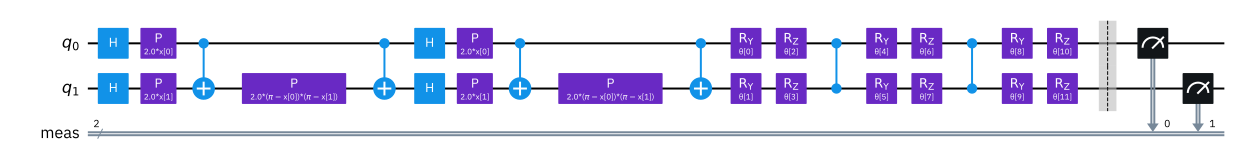

In [2]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

adhoc_feature_map = ZZFeatureMap(feature_dimension=2, reps=2)
adhoc_var_form = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

adhoc_circuit = adhoc_feature_map.compose(adhoc_var_form)
adhoc_circuit.measure_all()
adhoc_circuit.decompose().draw(style="textbook")

3. We create a function that associates the data to the feature map and the variational parameters to the variational circuit. This is to ensure that the right parameters in the circuit are associated with the right quantities.

In [3]:
def circuit_parameters(data, variational):
    parameters = {}
    for i, p in enumerate(adhoc_feature_map.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(adhoc_var_form.ordered_parameters):
        parameters[p] = variational[i]
    return parameters

4. We create a class assignment function to calculate the parity of the given bitstring. If the parity is even, it returns a $1$ label, and if the parity is odd it returns a $0$ label, as per Reference 3.

In [4]:
def assign_label(bitstring):
    hamming_weight = sum([int(k) for k in list(bitstring)])
    odd = hamming_weight & 1
    if odd:
        return 0
    else:
        return 1

5. We create a function the returns the probability distribution over the label classes, given experimental counts from running the quantum circuit multiple times.

In [5]:
def label_probability(results):
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = assign_label(bitstring)
        probabilities[label] += counts / shots
    return probabilities

6. We create a function that classifies our data. It takes in data and parameters. For every data point in the dataset, we assign the parameters to the feature map and the parameters to the variational circuit. We then evolve our system and store the quantum circuit, so as to run the circuits at once at the end. We measure each circuit and return the probabilities based on the bit string and class labels.

In [6]:
from qiskit import BasicAer, execute

def classification_probability(data, variational):
    circuits = [adhoc_circuit.assign_parameters(
        circuit_parameters(d,variational)) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results =  execute(circuits, backend).result()

    classification = [label_probability(results.get_counts(c)) for c in circuits]
    return classification

7. For training, we create the loss and cost functions.

In [7]:
def cross_entropy_loss(predictions, expected):
    p = predictions.get(expected)
    return -(expected*np.log(p)+(1-expected)*np.log(1-p))
   
def cost_function(data, labels, variational):
    classifications = classification_probability(data, variational)

    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)

    return cost

8. We set up our classical optimizer, using [`SPSA`](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html) as per Reference [3, initialize our variational circuit parameters for reproducibility, and optimize our cost function modifying the variational circuit parameters, using our 40 training datapoints. Note that the optimization will take a while to run. 

In [8]:
# Callback function for optimiser for plotting purposes
def store_intermediate_result(evaluation, parameter, cost, 
                              stepsize, accept):
    evaluations.append(evaluation)
    parameters.append(parameter)
    costs.append(cost)

In [9]:
# Set up the optimization
from qiskit.algorithms.optimizers import SPSA

parameters = []
costs = []
evaluations = []

optimizer = SPSA(maxiter=100, callback=store_intermediate_result)

#initial_point = np.random.random(adhoc_var_form.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

objective_function = lambda variational: cost_function(train_data,
                                                       train_labels,
                                                       variational)

In [10]:
# Run the optimization
opt_var, opt_value, _ = optimizer.optimize(len(initial_point), objective_function, initial_point=initial_point)

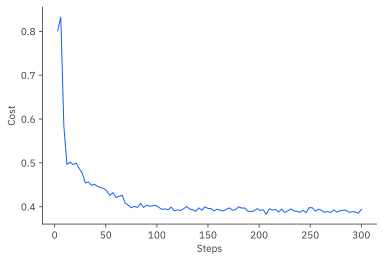

In [11]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

Plotting the cost function with respect to optimization step, we can see it converge to a minimum.

9. We implement a function to score our variational quantum classifier, using the classification function we created earlier, and use it to test our trained classifer on our 10 test datapoints.

In [12]:
def score_classifier(data, labels, variational):
    probability = classification_probability(data, variational)

    prediction = [0 if p[0] >= p[1] else 1 for p in probability]
    
    accuracy = 0
    for i, p in enumerate(probability):
        if (p[0] >= p[1]) and (labels[i] == 0):
            accuracy += 1
        elif (p[1]) >= p[0] and (labels[i] == 1):
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, prediction

In [13]:
accuracy, prediction = score_classifier(test_data, test_labels, opt_var)
accuracy

0.4

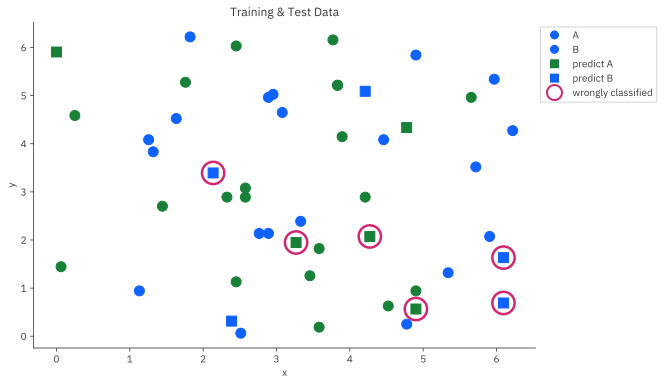

In [23]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(train_data, train_labels):
    marker = 'o' 
    color = 'C0' if label == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker=marker, s=100, color=color)
    
for feature, label, pred in zip(test_data, test_labels, prediction):
    marker = 's' 
    color = 'C0' if pred == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker=marker, s=100, color=color)
    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')
    
plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We see that the performance of the trained classifier is not great on the test data. The training optimization probably found a [local minimum](gloss:local-minimum), rather than the [global minimum](gloss:global-minimum).

### Qiskit Implementation

Qiskit has an implementation of the variational quantum classifer in the [`VQC`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html) class. Let's use it on the same dataset. 

First, we need to one hot encode our labels, as required by the algorithm.

In [15]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(train_labels.reshape(-1, 1)).toarray()
test_labels_oh = encoder.fit_transform(test_labels.reshape(-1, 1)).toarray()

Next, we set up and run the `VQC` algorithm, setting initial variational circuit parameters for reproducibility and using the callback function we created earlier to plot the results, then plot the results.

In [16]:
parameters = []
costs = []
evaluations = []

#initial_point = np.random.random(adhoc_var_form.num_parameters)
initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
                          0.96566328, 0.38243769, 0.90403094,
                          0.82271449, 0.26810137, 0.61076489,
                          0.82301609, 0.11789148, 0.29667125])

In [17]:
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(feature_map=adhoc_feature_map,
          ansatz=adhoc_var_form,
          loss='cross_entropy',
          optimizer=SPSA(callback=store_intermediate_result),
          initial_point=initial_point,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

In [18]:
vqc.fit(train_data, train_labels_oh)

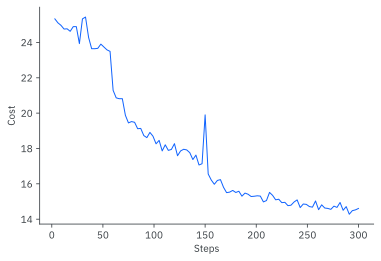

In [19]:
fig = plt.figure()
plt.plot(evaluations, costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

Third, we test the trained classifier on the test data.

In [20]:
vqc.score(test_data, test_labels_oh)

0.9

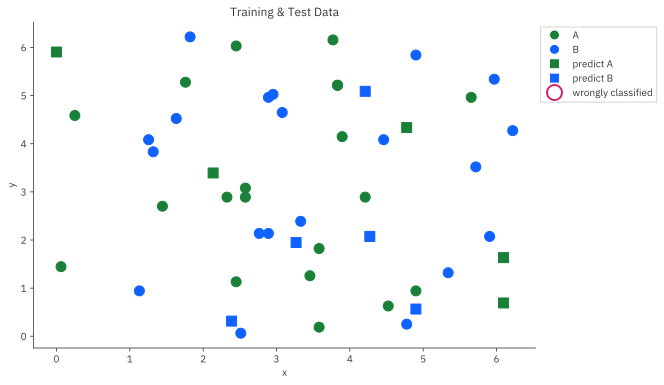

In [21]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(train_data, train_labels_oh):
    color = 'C1' if label[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='o', s=100,
                color=color)
    
for feature, label, pred in zip(test_data, test_labels_oh,
                                vqc.predict(test_data)): 
    color = 'C1' if pred[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='s', s=100, color=color)
    if not np.array_equal(label,pred):  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')
    
plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

We see that the performance of the trained classifier is pretty good on the test data. The training optimization probably found the global minimum.

## Variational Training

As with all variational algorithms, finding the optimal parameters of the variational circuit takes most of the processing time, and is dependent on the optimization method used, as discussed in the [training page](./training-quantum-circuits).

![](images/vqc/va.svg)

Our optimal circuit parameters, $\vec{\theta}^*$ are found when we find the minimum of the loss function, $f(\vec{\theta})$. However, there isn't a simple relationship between the loss function and the circuit parameters. In fact, the loss landscape can be quite complicated, as shown in hills and valleys of the example below. The optimization method navigates us around the loss landscape, searching for the minimum, as shown by the black points and lines. we can see that two of the three searches end up in a local landscape minimum, rather than a global one. 

![](images/vqc/loss-landscape.png)

Generally the optimization methods can be categorised into two groups: gradient-based and gradient-free methods. To determine an optimal solution, gradient-based methods identify an extreme point at which the gradient is equal to zero. A search direction is selected and the searching direction is determined by the derivative of the loss function. The main disadvantages of this type of optimization are the convergence speed can be very slow and there is no guarantee to achieve the optimal solution. 

When derivative information is unavailable or impractical to obtain (e.g. when the loss function is expensive to evaluate or somewhat noisy), gradient-free methods can be very useful. Such optimisation techniques are robust to find the global optima, while the gradient-based methods tend to converge into local optima. However, gradient-free methods require higher computational capacities, especially for the problems with high-dimensional search spaces.

![](images/vqc/barren-plateaus.png)

Despite what type of optimization method is used, if the loss landscape is fairly flat, it can be difficult for the method to determine which direction to search. This situation is called a _[barren plateau](gloss:barren-plateaus),_ and was studied in Reference 4, where it was hown that show that for a wide class of reasonable parameterized quantum circuits, the probability that the gradient along any reasonable direction is non-zero to some fixed precision is exponentially small as a function of the number of qubits.

There are two possible ways to face the problem of barren plateaus. One approach is to use structured initial guesses, such as those adopted in quantum simulation. Another possibility is to consider the full quantum circuit as a sequence of shallow blocks, selecting some parameters randomly and choosing the rest of the parameters such that all shallow blocks implement the identity to restrict the effective depth. This is an area of current investigation.

## References

1. Alberto Peruzzo, Jarrod McClean, Peter Shadbolt, Man-Hong Yung, Xiao-Qi Zhou, Peter J. Love, Alán Aspuru-Guzik and Jeremy L. O'Brien, *A variational eigenvalue solver on a quantum processor*, Nature Communications, 5:4213 (2014), [doi.org:10.1038/ncomms5213](https://doi.org/10.1038/ncomms5213), [arXiv:1304.3061](https://arxiv.org/abs/1304.3061).
1. Edward Farhi, Jeffrey Goldstone and Sam Gutmann, *A Quantum Approximate Optimization Algorithm* (2014), [arXiv:1411.4028](https://arxiv.org/abs/1411.4028).
1. Vojtech Havlicek, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav  Kandala, Jerry M. Chow and Jay M. Gambetta, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209-212 (2019), [doi.org:10.1038/s41586-019-0980-2](https://doi.org/10.1038/s41586-019-0980-2), [arXiv:1803.07128](https://arxiv.org/abs/1803.07128).
1. Jarrod R. McClean, Sergio Boixo, Vadim N. Smelyanskiy, Ryan Babbush and Hartmut Neven, *Barren plateaus in quantum neural network training landscapes*, Nature Communications volume 9, Article number: 4812 (2018), [doi.org:10.1038/s41467-018-07090-4](https://www.nature.com/articles/s41467-018-07090-4) [arXiv:1803.1117](https://arxiv.org/abs/1803.11173)

In [22]:
import qiskit.tools.jupyter
%qiskit_version_table

/usr/local/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
